In [1]:
from datetime import datetime 
import pandas as pd
from utils import simulator_period,save_sim_resuls
from subjects.corr_coef import CorrCoeff,TrendFunc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
casino_fig=pd.read_csv('casino_fig.csv', parse_dates = ['Date'])
casino_fig['week_day'] = casino_fig['Date'].dt.dayofweek

In [4]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day
0,2022-01-01,34,2924.200831,57765.485289,4033,5
1,2022-01-02,19,507.688859,66719.293514,2062,6
2,2022-01-03,20,1737.412798,33983.499611,2166,0
3,2022-01-04,12,131.994872,45132.474347,1214,1
4,2022-01-05,8,-381.229482,49338.352483,1528,2


In [5]:
casino_fig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1097 non-null   datetime64[ns]
 1   Heads        1097 non-null   int64         
 2   Day_Result   1097 non-null   float64       
 3   Total_Bets   1097 non-null   float64       
 4   Total_Hands  1097 non-null   int64         
 5   week_day     1097 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2)
memory usage: 47.3 KB


<Axes: xlabel='Date'>

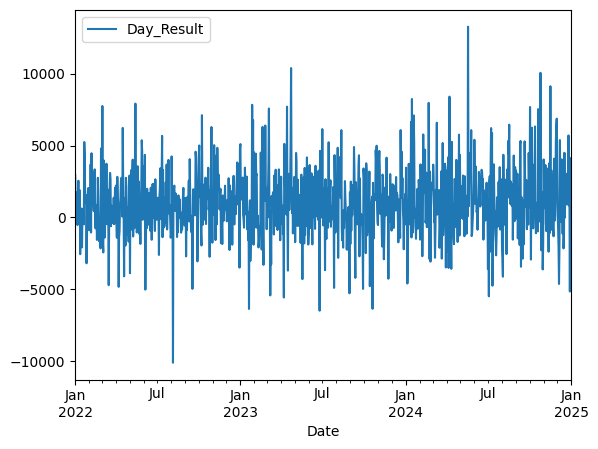

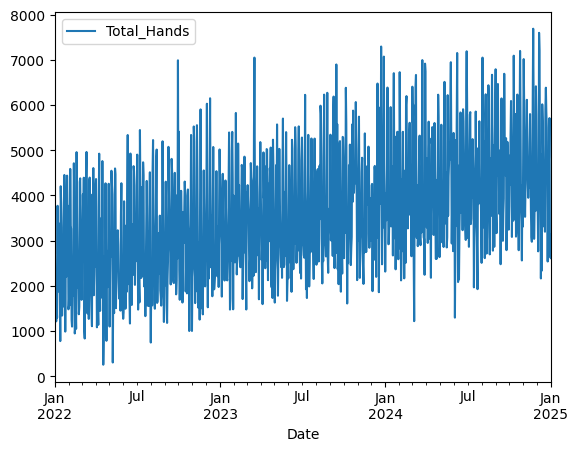

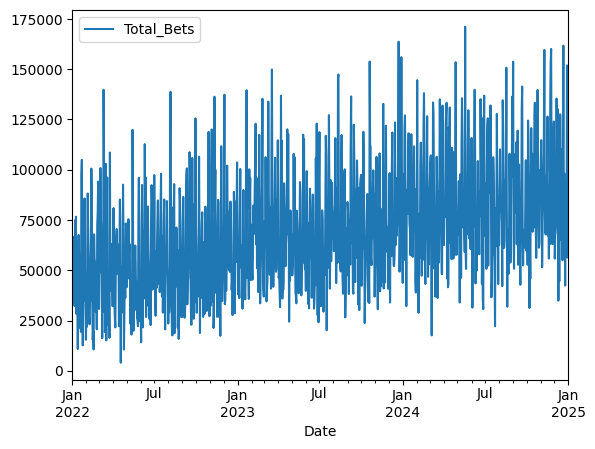

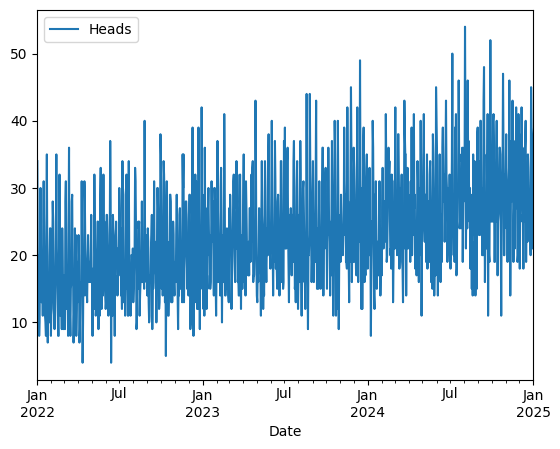

In [6]:
casino_fig[:].plot(x="Date", y ="Day_Result")
casino_fig[:].plot(x="Date", y ="Total_Hands")
casino_fig[:].plot(x="Date", y ="Total_Bets")
casino_fig[:].plot(x="Date", y ="Heads")


In [7]:
casino_fig_train = casino_fig[casino_fig['Date'] < datetime(2024,11,1) ]
casino_fig_test = casino_fig[casino_fig['Date'] >= datetime(2024,11,1) ]

In [8]:
casino_fig_test.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day
1035,2024-11-01,33,4030.822714,104002.498769,5174,4
1036,2024-11-02,38,2018.159726,114709.056131,7017,5
1037,2024-11-03,24,641.435058,92594.662697,6036,6
1038,2024-11-04,29,1279.630712,51465.393329,4282,0
1039,2024-11-05,19,3641.901367,69018.323551,3527,1


In [9]:
casino_fig_train.tail()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day
1030,2024-10-27,36,-2291.017382,99988.948920,3765,6
1031,2024-10-28,20,971.675578,61242.890602,3431,0
1032,2024-10-29,20,1760.701704,63244.825253,2561,1
1033,2024-10-30,32,-3621.815072,95881.172234,4218,2
1034,2024-10-31,27,-1916.719734,93529.206050,3309,3


In [10]:
casino_fig_train['Heads_ewm'] = casino_fig_train['Heads'].ewm(span=7, adjust=True).mean()

<Axes: xlabel='Date'>

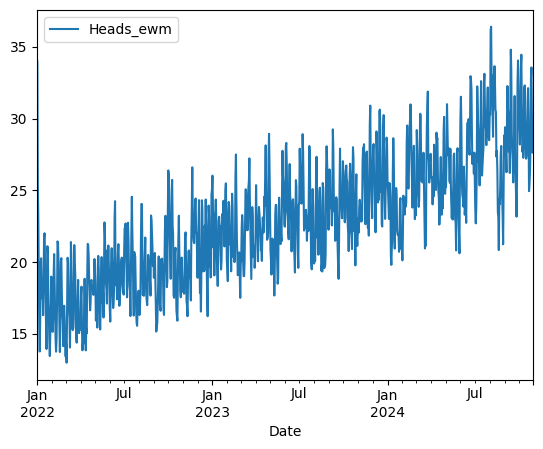

In [11]:
casino_fig_train.plot(x="Date", y ="Heads_ewm")

In [12]:
coefficients = np.polyfit(casino_fig_train.index,casino_fig_train['Heads'], 1)
print(coefficients)

[1.16838741e-02 1.68657173e+01]


In [13]:
poly_1 = np.poly1d(coefficients)

In [14]:
casino_fig_train['trend_heads']= poly_1(casino_fig_train.index)

<Axes: xlabel='Date'>

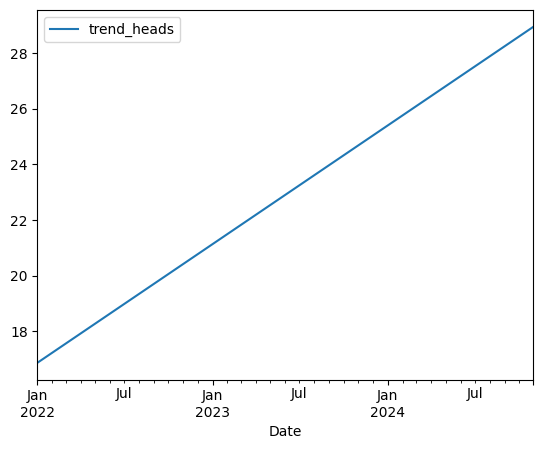

In [15]:
casino_fig_train.plot(x="Date", y ="trend_heads")

In [16]:
casino_fig_train['heads_center_and_clear']=casino_fig_train['Heads']-casino_fig_train['trend_heads']

<Axes: xlabel='Date'>

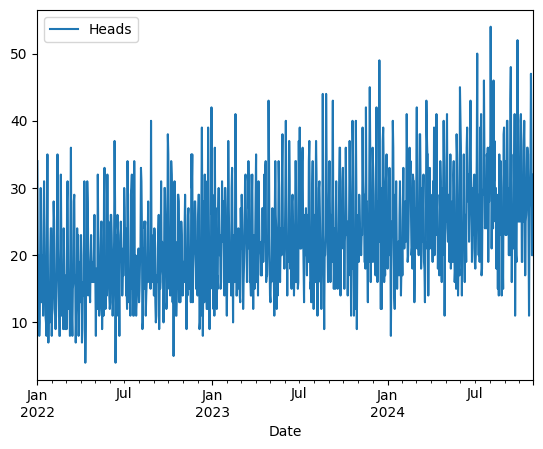

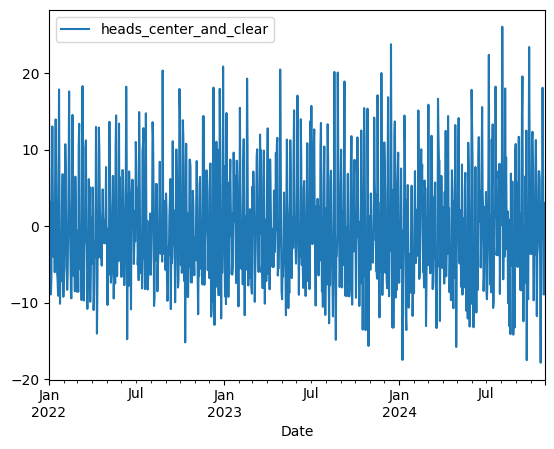

In [17]:
casino_fig_train.plot(x="Date", y ="Heads")
casino_fig_train.plot(x="Date", y ="heads_center_and_clear")

In [18]:
heads_train_df =casino_fig_train.groupby('week_day')['heads_center_and_clear'].agg([ 'mean','std'])

In [19]:
heads_train_df

,mean,std
week_day,,
0,-6.049087,4.667290
1,-5.398609,4.251917
2,-2.707590,4.230763
3,-4.753057,3.658240
4,7.427053,5.797445
5,8.812119,6.158895
6,2.719354,5.254307


In [20]:
casino_fig_test['trend_heads']= poly_1(casino_fig_test.index)

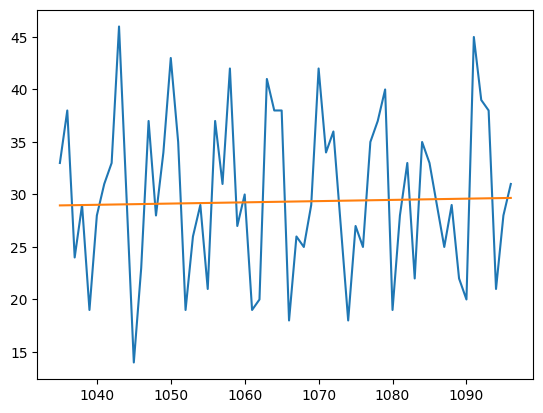

In [21]:
plt.plot(casino_fig_test.index ,casino_fig_test['Heads'] )
plt.plot(casino_fig_test.index ,casino_fig_test['trend_heads'] )

In [22]:
casino_fig_test.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day,trend_heads
1035,2024-11-01,33,4030.822714,104002.498769,5174,4,28.958527
1036,2024-11-02,38,2018.159726,114709.056131,7017,5,28.970211
1037,2024-11-03,24,641.435058,92594.662697,6036,6,28.981895
1038,2024-11-04,29,1279.630712,51465.393329,4282,0,28.993579
1039,2024-11-05,19,3641.901367,69018.323551,3527,1,29.005262


In [23]:
predict = []
predict_3_std_plus = []
predict_3_std_minus = []
for curr_ind in casino_fig_test.index:
    week_day = casino_fig_test['week_day'].loc[curr_ind]
    trend = casino_fig_test['trend_heads'].loc[curr_ind]
    pred = trend + heads_train_df['mean'].loc[week_day]
    predict.append(pred)
    predict_3_std_plus.append(pred+3*heads_train_df['std'].loc[week_day])
    predict_3_std_minus.append(pred-3*heads_train_df['std'].loc[week_day])
    

In [24]:
casino_fig_test['predict'] = predict
casino_fig_test['predict_3_std_plus'] = predict_3_std_plus
casino_fig_test['predict_3_std_minus'] = predict_3_std_minus

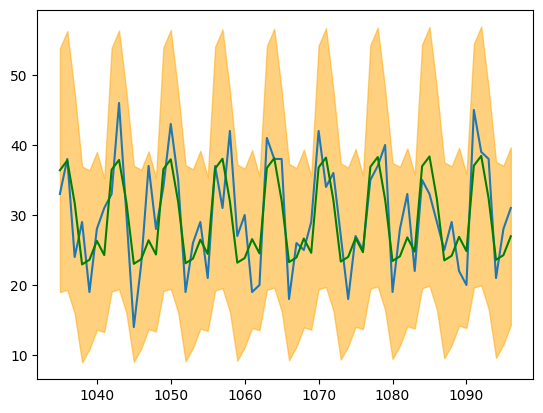

In [25]:
plt.plot(casino_fig_test.index ,casino_fig_test['Heads'] )
plt.plot(casino_fig_test.index ,casino_fig_test['predict'],color='green' )
plt.fill_between(casino_fig_test.index, casino_fig_test['predict_3_std_minus'], casino_fig_test['predict_3_std_plus'], alpha=0.5, color='orange')

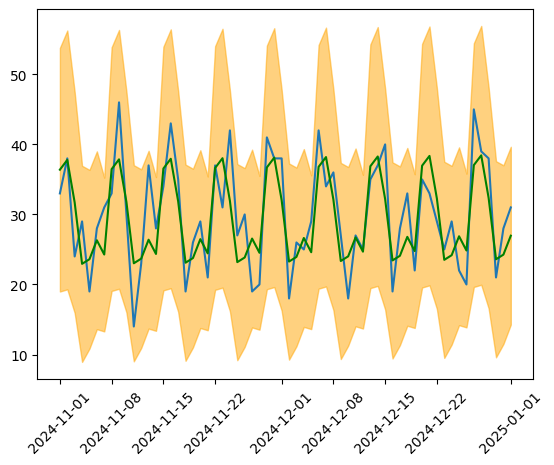

In [27]:
plt.plot(casino_fig_test['Date']  ,casino_fig_test['Heads'] )
plt.plot(casino_fig_test['Date'],casino_fig_test['predict'],color='green' )
plt.fill_between(casino_fig_test['Date'], casino_fig_test['predict_3_std_minus'], casino_fig_test['predict_3_std_plus'], alpha=0.5, color='orange')
plt.tick_params(axis='x', labelrotation=45)